## Libraries

In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import random
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Directories

In [ ]:
# Define the paths to the dataset directories
train_dir = "/content/drive/MyDrive/DS 5500/Phase2/training"
validation_dir = "/content/drive/MyDrive/DS 5500/Phase2/validation"
test_dir = "/content/drive/MyDrive/DS 5500/Phase2/evaluation"

## EDA

### Class Distribution - Train

Number of classes: 2
Class: food | Number of images in train directory: 1500
Class: non_food | Number of images in train directory: 1506


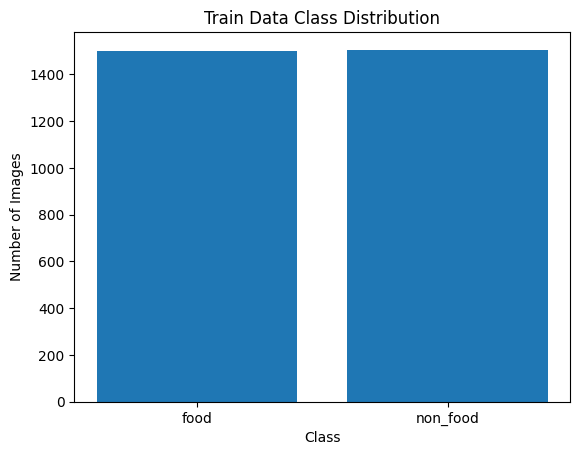

In [ ]:
# Perform exploratory data analysis (EDA)
classes = ["food", "non_food"]
num_classes = len(classes)
print("Number of classes:", num_classes)
class_counts = []
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    class_images = os.listdir(class_dir)
    class_counts.append(len(class_images))
    print("Class:", class_name, "| Number of images in train directory:", len(class_images))

plt.bar(classes, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Train Data Class Distribution")
plt.show()

### Class Distribution - Validation

Number of classes: 2
Class: food | Number of images in validation directory: 500
Class: non_food | Number of images in validation directory: 500


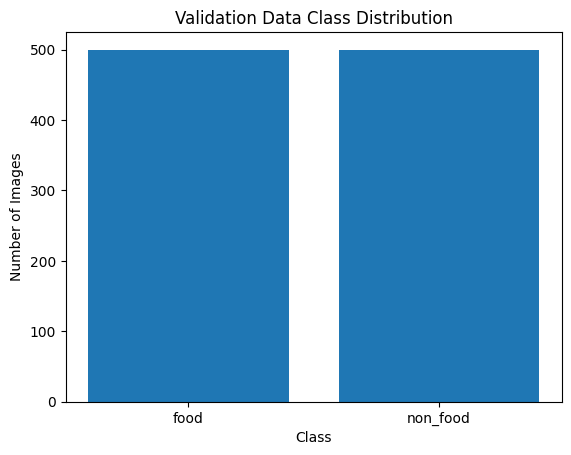

In [ ]:
classes = ["food", "non_food"]
num_classes = len(classes)
print("Number of classes:", num_classes)
class_counts = []
for class_name in classes:
    class_dir = os.path.join(validation_dir, class_name)
    class_images = os.listdir(class_dir)
    class_counts.append(len(class_images))
    print("Class:", class_name, "| Number of images in validation directory:", len(class_images))

plt.bar(classes, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Validation Data Class Distribution")
plt.show()

### Class Distribution - Test

Number of classes: 2
Class: food | Number of images in evaluation directory: 500
Class: non_food | Number of images in evaluation directory: 500


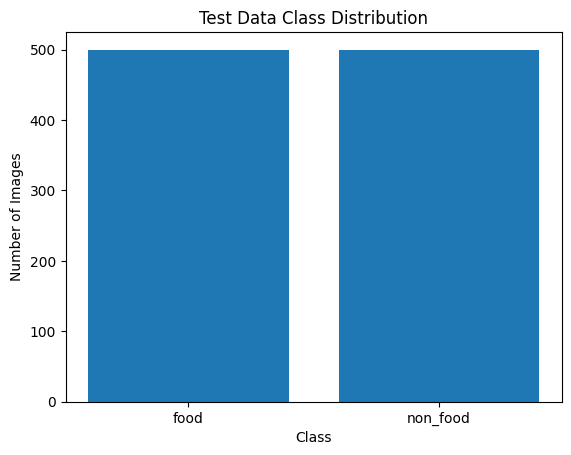

In [ ]:
classes = ["food", "non_food"]
num_classes = len(classes)
print("Number of classes:", num_classes)
class_counts = []
for class_name in classes:
    class_dir = os.path.join(test_dir, class_name)
    class_images = os.listdir(class_dir)
    class_counts.append(len(class_images))
    print("Class:", class_name, "| Number of images in evaluation directory:", len(class_images))

plt.bar(classes, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Test Data Class Distribution")
plt.show()

### Food Images

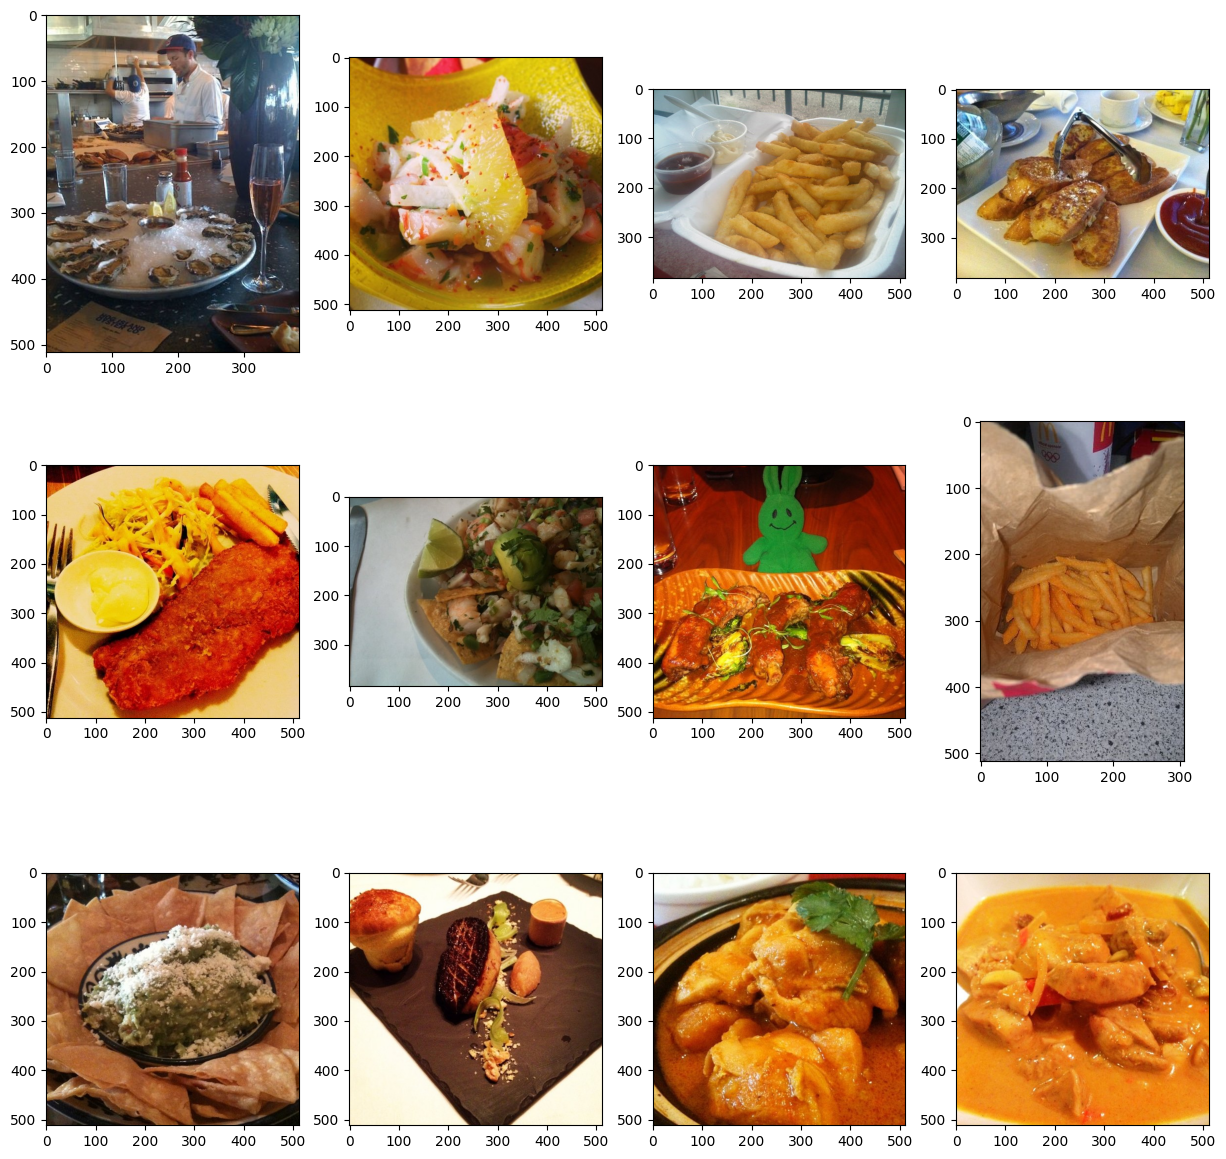

In [ ]:
plt.figure(figsize=(15,15))
food_images="/content/drive/MyDrive/DS 5500/Phase2/training/food/"
for i in range(12):
    file=random.choice(os.listdir(food_images))
    food_image_path=os.path.join(food_images,file)
    img=mpimg.imread(food_image_path)
    ax=plt.subplot(3,4,i+1)
    plt.imshow(img)
plt.show()

### Non-food Images

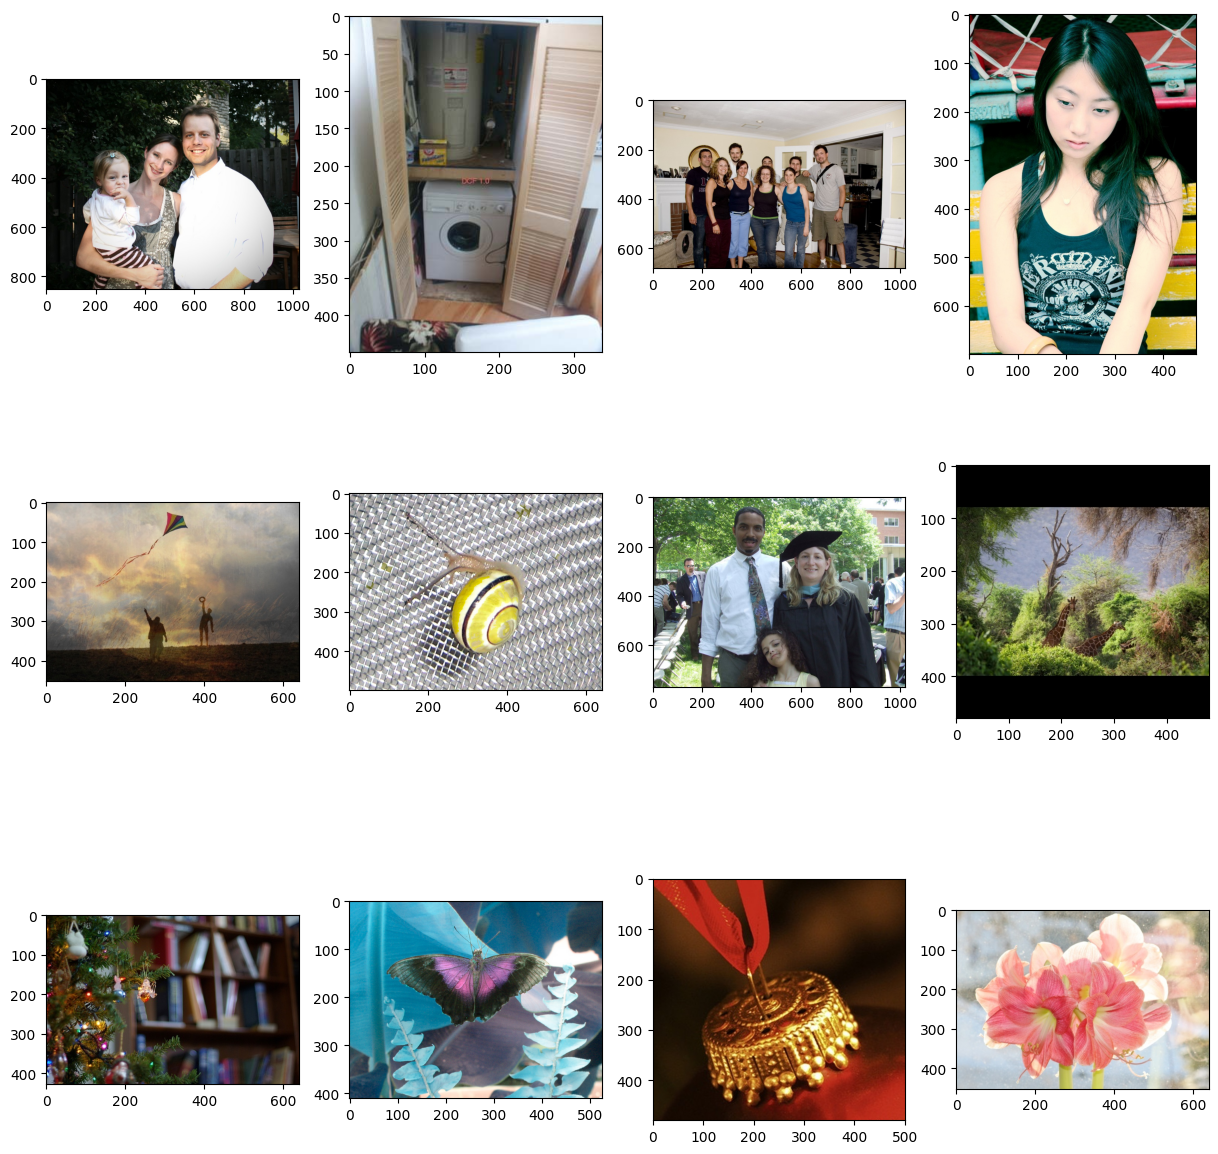

In [ ]:
plt.figure(figsize=(15,15))
non_food_images="/content/drive/MyDrive/DS 5500/Phase2/training/non_food/"
for i in range(12):
    file=random.choice(os.listdir(non_food_images))
    non_food_image_path=os.path.join(non_food_images,file)
    img=mpimg.imread(non_food_image_path)
    ax=plt.subplot(3,4,i+1)
    plt.imshow(img)
plt.show()

## Preprocessing

In [ ]:
# Preprocessing
classes = ["food", "non_food"]
image_size = (224, 224) # Set desired image size
batch_size = 32 # Set desired batch size


# Use ImageDataGenerator for data loading and augmentation
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0, # Rescale images to range [0, 1]
                             rotation_range=20,
                             horizontal_flip=True,
                             zoom_range=0.2)
# Use ImageDataGenerator for data loading and augmentation
valtest_datagen = ImageDataGenerator(rescale=1.0 / 255.0) # Rescale images to range [0, 1]


# Load and preprocess training images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
)

# Load and preprocess validation images
validation_generator = valtest_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
)

# Load and preprocess test images
test_generator = valtest_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
)

# Class indices from the generator
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)

# Number of classes
num_classes = len(class_indices)
print("Number of Classes:", num_classes)


Found 3006 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Indices: {'food': 0, 'non_food': 1}
Number of Classes: 2


In [ ]:
# Number of original images in the training data
num_original_images = len(train_generator.filenames)

# Number of extra images due to rotation
num_extra_rotation = num_original_images * 41

# Number of extra images due to horizontal flip
num_extra_horizontal_flip = num_original_images

# Number of extra images due to zoom
num_extra_zoom = num_original_images * 5

# Overall total number of extra images
total_extra_images = num_extra_rotation + num_extra_horizontal_flip + num_extra_zoom

print("Total number of extra images in the training data:", total_extra_images)


Total number of extra images in the training data: 141282


# CNN

In [ ]:
# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# Model Summary
model.summary()

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (validation loss in this case)
    patience=5,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restores the best weights from the epoch with the lowest validation loss
)

In [ ]:
# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=30,
    batch_size=batch_size,
    validation_data=validation_generator,
    callbacks=[early_stopping]   # Include the EarlyStopping callback in the list of callbacks
)
history

In [ ]:
# Save entire model
model.save('CNN_Food_5k.h5')

## Classification Report

In [ ]:
# Step 1: Predict labels for the full validation data
validation_steps = len(validation_generator)
predicted_class_indices = []
true_class_labels = []

# Iterate through all batches in the validation generator
for batch_index in range(validation_steps):
    images, labels = next(validation_generator)
    predicted_probabilities = model.predict(images)
    predicted_class_indices.extend(np.argmax(predicted_probabilities, axis=1))
    true_class_labels.extend(labels)

# Convert the true class labels to integer values
true_class_labels = np.asarray(true_class_labels, dtype=int)

# Step 2: Generate the classification report
report = classification_report(true_class_labels, predicted_class_indices, target_names=classes)
print("Classification Report:\n", report)

## Confusion Matrix

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_class_labels, predicted_class_indices)
print("Confusion Matrix:\n", conf_matrix)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)

# Adjust figure size
fig, ax = plt.subplots(figsize=(5, 5))


# Plot the confusion matrix
disp.plot(ax=ax, cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')

# Rotate xticks vertically
plt.xticks(rotation='vertical')


plt.tight_layout()
plt.show()

## Plot Accuracy and Loss

In [ ]:
# Plotting accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

## Evaluating

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

In [ ]:
# Step 1: Get a batch of images and labels from the test_generator
images, labels = next(test_generator)

# Step 2: Choose one image from the batch (e.g., the first image in the batch)
chosen_image = images[0]
chosen_label = int(labels[0])

# Step 3: Preprocess the image to match the input format of your model
# Assuming your model expects images in the shape (batch_size, height, width, channels),
# you can add an extra dimension to the chosen image (batch_size=1) using np.expand_dims
chosen_image = np.expand_dims(chosen_image, axis=0)

# Step 4: Use the model to predict the class label for the chosen image
predicted_probabilities = model.predict(chosen_image)
predicted_class_index = np.argmax(predicted_probabilities)
predicted_class_label = classes[predicted_class_index]

# Step 5: Display the chosen image along with the predicted class label
plt.imshow(chosen_image[0])
plt.title(f"True Label: {classes[chosen_label]}, Predicted Label: {predicted_class_label}")
plt.axis('off')
plt.show()

# InceptionV3

In [ ]:
# Assuming num_classes is 1 for binary classification
num_classes = 1

# Build InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)  # Use 'sigmoid' for binary classification
model_2 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Model Summary
model_2.summary()

In [ ]:
# Compile the model
model_2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Training

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (validation loss in this case)
    patience=5,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restores the best weights from the epoch with the lowest validation loss
)

In [ ]:
# Train the model with early stopping
history = model_2.fit(
    train_generator,
    epochs=30,
    batch_size=batch_size,
    validation_data=validation_generator,
    callbacks=[early_stopping]   # Include the EarlyStopping callback in the list of callbacks
)
history

In [ ]:
# Save entire model
model_2.save('InceptionV3_Food_5k.h5')

## Classification Report

In [ ]:
# Step 1: Predict probabilities for the full validation data
validation_steps = len(validation_generator)
predicted_probabilities = []
true_class_labels = []

# Iterate through all batches in the validation generator
for batch_index in range(validation_steps):
    images, labels = next(validation_generator)
    batch_probabilities = model_2.predict(images)
    predicted_probabilities.extend(batch_probabilities)
    true_class_labels.extend(labels)

# Convert the true class labels to integer values
true_class_labels = np.asarray(true_class_labels, dtype=int)

# Convert the predicted probabilities to binary class labels using a threshold
threshold = 0.5
predicted_class_indices = np.asarray(predicted_probabilities) >= threshold
predicted_class_indices = predicted_class_indices.astype(int)

# Step 2: Generate the classification report
report = classification_report(true_class_labels, predicted_class_indices, target_names=classes)
print("Classification Report:\n", report)

## Confusion Matrix

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_class_labels, predicted_class_indices)
print("Confusion Matrix:\n", conf_matrix)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)

# Adjust figure size
fig, ax = plt.subplots(figsize=(5, 5))


# Plot the confusion matrix
disp.plot(ax=ax, cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')

# Rotate xticks vertically
plt.xticks(rotation='vertical')


plt.tight_layout()
plt.show()

## Plot Accuracy and Loss

In [ ]:
# Plotting accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

## Evaluating

In [ ]:
# Evaluate the model
loss, accuracy = model_2.evaluate(test_generator)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

In [ ]:
# Step 1: Get a batch of images and labels from the test_generator
images, labels = next(test_generator)

# Step 2: Choose one image from the batch (e.g., the first image in the batch)
chosen_image = images[0]
chosen_label = int(labels[0])

# Step 3: Preprocess the image to match the input format of your model
# Assuming your model expects images in the shape (batch_size, height, width, channels),
# you can add an extra dimension to the chosen image (batch_size=1) using np.expand_dims
chosen_image = np.expand_dims(chosen_image, axis=0)

# Step 4: Use the model to predict the class probabilities for the chosen image
predicted_probabilities = model_2.predict(chosen_image)

# Step 5: Set a threshold (e.g., 0.5) to convert probabilities to binary class labels
threshold = 0.5
predicted_class_labels = (predicted_probabilities >= threshold).astype(int)

# Step 6: Get the predicted class label for the chosen image
predicted_class_index = np.argmax(predicted_class_labels[0])
predicted_class_label = classes[predicted_class_index]

# Step 7: Display the chosen image along with the predicted class label
plt.imshow(chosen_image[0])
plt.title(f"True Label: {classes[chosen_label]}, Predicted Label: {predicted_class_label}")
plt.axis('off')
plt.show()


# Vision Transformer

In [ ]:
# Model hyperparameters
image_size = 224
patch_size = 16
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [128]

# Input layer
inputs = layers.Input(shape=(image_size, image_size, 3))

# Create patches
# patches = Patches(patch_size)(inputs)
patches = layers.Reshape((num_patches, patch_size**2 * 3))(inputs)

# Encode patches
encoded_patches = layers.LayerNormalization()(patches)
encoded_patches = layers.Dense(projection_dim)(encoded_patches)

# Transformer encoder
for _ in range(transformer_layers):
    # Self-attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(encoded_patches, encoded_patches)
    attention_output = layers.Dropout(0.1)(attention_output)
    attention_output = layers.LayerNormalization()(encoded_patches + attention_output)

    # MLP layer
    x = layers.Dense(transformer_units[0], activation="gelu")(attention_output)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(projection_dim)(x)
    encoded_patches = layers.Dropout(0.1)(attention_output + x)
    encoded_patches = layers.LayerNormalization()(encoded_patches)

# Classify outputs
representation = layers.LayerNormalization()(encoded_patches)
representation = tf.reduce_mean(representation, axis=1) # global average pooling
for units in mlp_head_units:
    representation = layers.Dense(units, activation="relu")(representation)
outputs = layers.Dense(1)(representation)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)
model.summary()

## Training

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (validation loss in this case)
    patience=5,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restores the best weights from the epoch with the lowest validation loss
)

In [ ]:
# Load your training data and specify the target image size (resize if necessary)
# Make sure your training data is organized in the appropriate directory structure.
# Example: train_data = train_datagen.flow_from_directory('path/to/training_data', target_size=(image_size, image_size), batch_size=batch_size)

# Train the model with early stopping
history = model.fit(train_generator,
    epochs=30,
    batch_size=batch_size,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)
history

Epoch 1/30
94/94 [==============================] - 497s 5s/step - loss: 0.6509 - binary_accuracy: 0.6134 - val_loss: 0.5717 - val_binary_accuracy: 0.7200
Epoch 2/30
94/94 [==============================] - 429s 5s/step - loss: 0.5930 - binary_accuracy: 0.6926 - val_loss: 0.5666 - val_binary_accuracy: 0.7270
Epoch 3/30
94/94 [==============================] - 468s 5s/step - loss: 0.5769 - binary_accuracy: 0.7112 - val_loss: 0.5551 - val_binary_accuracy: 0.7360
Epoch 4/30
94/94 [==============================] - 427s 5s/step - loss: 0.5602 - binary_accuracy: 0.7176 - val_loss: 0.5347 - val_binary_accuracy: 0.7440
Epoch 5/30
94/94 [==============================] - 427s 5s/step - loss: 0.5457 - binary_accuracy: 0.7309 - val_loss: 0.5240 - val_binary_accuracy: 0.7540
Epoch 6/30
94/94 [==============================] - 469s 5s/step - loss: 0.5278 - binary_accuracy: 0.7495 - val_loss: 0.5100 - val_binary_accuracy: 0.7570
Epoch 7/30
94/94 [==============================] - 431s 5s/step - los

KeyboardInterrupt: ignored

In [ ]:
# Save entire model
model.save('ViT_Food_5k.h5')

## Classification Report

In [ ]:
# Step 1: Predict probabilities for the full validation data
validation_steps = len(validation_generator)
predicted_probabilities = []
true_class_labels = []

# Iterate through all batches in the validation generator
for batch_index in range(validation_steps):
    images, labels = next(validation_generator)
    batch_probabilities = model.predict(images)
    predicted_probabilities.extend(batch_probabilities)
    true_class_labels.extend(labels)

# Convert the true class labels to integer values
true_class_labels = np.asarray(true_class_labels, dtype=int)

# Convert the predicted probabilities to binary class labels using a threshold
threshold = 0.5
predicted_class_indices = np.asarray(predicted_probabilities) >= threshold
predicted_class_indices = predicted_class_indices.astype(int)

# Step 2: Generate the classification report
report = classification_report(true_class_labels, predicted_class_indices, target_names=classes)
print("Classification Report:\n", report)

## Confusion Matrix

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_class_labels, predicted_class_indices)
print("Confusion Matrix:\n", conf_matrix)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)

# Adjust figure size
fig, ax = plt.subplots(figsize=(5, 5))


# Plot the confusion matrix
disp.plot(ax=ax, cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')

# Rotate xticks vertically
plt.xticks(rotation='vertical')


plt.tight_layout()
plt.show()

## Plot Accuracy and Loss

In [ ]:
# Plotting accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()

## Evaluating

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

In [ ]:
# Step 1: Get a batch of images and labels from the test_generator
images, labels = next(test_generator)

# Step 2: Choose one image from the batch (e.g., the first image in the batch)
chosen_image = images[0]
chosen_label = int(labels[0])

# Step 3: Preprocess the image to match the input format of your model
# Assuming your model expects images in the shape (batch_size, height, width, channels),
# you can add an extra dimension to the chosen image (batch_size=1) using np.expand_dims
chosen_image = np.expand_dims(chosen_image, axis=0)

# Step 4: Use the model to predict the class probabilities for the chosen image
predicted_probabilities = model.predict(chosen_image)

# Step 5: Set a threshold (e.g., 0.5) to convert probabilities to binary class labels
threshold = 0.5
predicted_class_labels = (predicted_probabilities >= threshold).astype(int)

# Step 6: Get the predicted class label for the chosen image
predicted_class_index = np.argmax(predicted_class_labels[0])
predicted_class_label = classes[predicted_class_index]

# Step 7: Display the chosen image along with the predicted class label
plt.imshow(chosen_image[0])
plt.title(f"True Label: {classes[chosen_label]}, Predicted Label: {predicted_class_label}")
plt.axis('off')
plt.show()